In [14]:
# General
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Prepo 1 (Visualisasi)
import missingno as mno
from fast_ml.feature_selection import get_duplicate_features

# Prepo 2
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import FunctionTransformer

# Model
from imblearn.over_sampling import ADASYN
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, make_scorer, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [15]:
feature = pd.read_csv(r'C:\Users\daffa\OneDrive - UGM 365\Keperluan Lomba\ICONIC\Iconic_2024\Dataset\Ekonomi\Credit_card.csv') 
label = pd.read_csv(r'C:\Users\daffa\OneDrive - UGM 365\Keperluan Lomba\ICONIC\Iconic_2024\Dataset\Ekonomi\Credit_card_label.csv')

In [16]:
# Gabungkan data feature dengan label dengan Ind_ID
data = pd.merge(feature, label, on='Ind_ID')
data

,Ind_ID,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Type_Occupation,Family_Members,label
0,5008827,M,Y,Y,0,180000.0,Pensioner,Higher education,Married,House / apartment,-18772.0,365243,1,0,0,0,NaN,2,1
1,5009744,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1
2,5009746,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,NaN,-586,1,1,1,0,NaN,2,1
3,5009749,F,Y,N,0,NaN,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1
4,5009752,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,5028645,F,N,Y,0,NaN,Commercial associate,Higher education,Married,House / apartment,-11957.0,-2182,1,0,0,0,Managers,2,0
1544,5023655,F,N,N,0,225000.0,Commercial associate,Incomplete higher,Single / not married,House / apartment,-10229.0,-1209,1,0,0,0,Accountants,1,0
1545,5115992,M,Y,Y,2,180000.0,Working,Higher education,Married,House / apartment,-13174.0,-2477,1,0,0,0,Managers,4,0
1546,5118219,M,Y,N,0,270000.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-15292.0,-645,1,1,1,0,Drivers,2,0


In [17]:
#  want to know unique value for each category data
for col in data.select_dtypes(include=['object', 'category']):
    print(f"Unique values for {col}: {data[col].unique()}")

Unique values for GENDER: ['M' 'F' nan]
Unique values for Car_Owner: ['Y' 'N']
Unique values for Propert_Owner: ['Y' 'N']
Unique values for Type_Income: ['Pensioner' 'Commercial associate' 'Working' 'State servant']
Unique values for EDUCATION: ['Higher education' 'Secondary / secondary special' 'Lower secondary'
 'Incomplete higher' 'Academic degree']
Unique values for Marital_status: ['Married' 'Single / not married' 'Civil marriage' 'Separated' 'Widow']
Unique values for Housing_type: ['House / apartment' 'With parents' 'Rented apartment'
 'Municipal apartment' 'Co-op apartment' 'Office apartment']
Unique values for Type_Occupation: [nan 'Core staff' 'Cooking staff' 'Laborers' 'Sales staff' 'Accountants'
 'High skill tech staff' 'Managers' 'Cleaning staff' 'Drivers'
 'Low-skill Laborers' 'IT staff' 'Waiters/barmen staff' 'Security staff'
 'Medicine staff' 'Private service staff' 'HR staff' 'Secretaries'
 'Realty agents']


In [18]:
# Menghapus kolom Ind_ID
data = data.drop(columns=['Ind_ID'])

In [19]:
# Ubah tipe Mobile_phone, Work_phone, Phone, Email, dan label menjadi kategori
data['Mobile_phone'] = data['Mobile_phone'].astype('category')
data['Work_Phone'] = data['Work_Phone'].astype('category')
data['Phone'] = data['Phone'].astype('category')
data['EMAIL_ID'] = data['EMAIL_ID'].astype('category')
data['label'] = data['label'].astype('category')

In [20]:
# Membuang feature 'Mobile_phone' karena hanya memiliki satu nilai
data = data.drop(columns=['Mobile_phone'])

In [21]:
# Membuang feature 'Mobile_phone' karena hanya memiliki satu nilai
data = data.drop(columns=['Propert_Owner'])

In [22]:
# Ensure 'Years_Employed' is added correctly
data['Years_Employed'] = data['Employed_days'] // 365

# Ensure that Birthday_count is positive
data['Birthday_count'] = data['Birthday_count'].abs()

# Create new features
data['Income_per_Family_Member'] = data['Annual_income'] / data['Family_Members']
data['Children_per_Family_Member'] = data['CHILDREN'] / data['Family_Members']
data['Is_Employed'] = data['Employed_days'] > 0

# Assuming data is your DataFrame and it has a 'label' column for the target variable
X = data.drop(columns='label')
y = data['label']

# Update the feature lists
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Define the numeric transformer
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Define the categorical transformer
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Define the preprocessor with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Set up oversampling with ADASYN
oversampler = ADASYN(random_state=42)

# Create and apply pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Preprocess the data
X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)

# # Oversampling
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_processed, y_train)

Classification Report for CatBoostClassifier:
              precision    recall  f1-score   support

           0      0.978     0.807     0.885       280
           1      0.316     0.833     0.459        30

    accuracy                          0.810       310
   macro avg      0.647     0.820     0.672       310
weighted avg      0.914     0.810     0.843       310



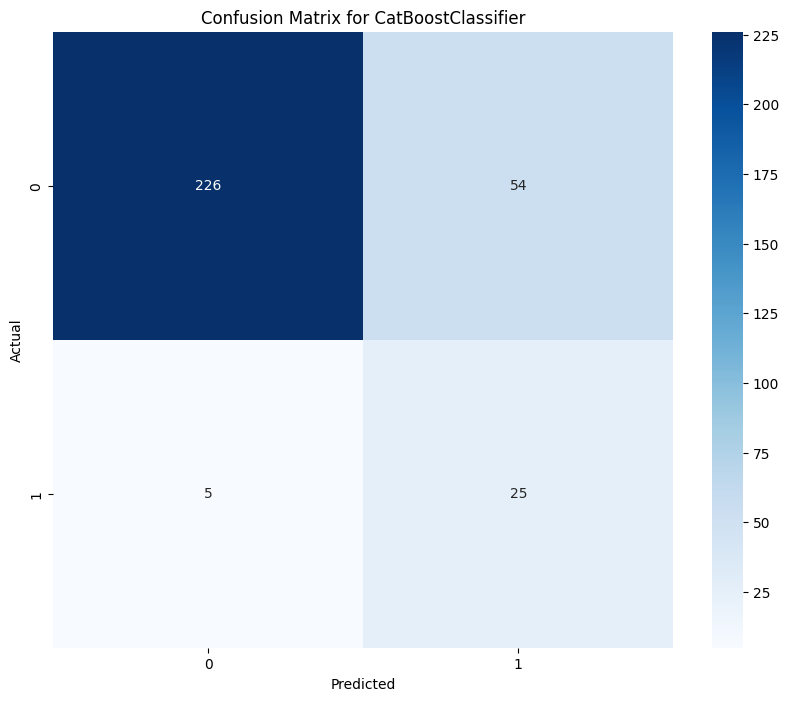

In [23]:
from sklearn.metrics import roc_curve, classification_report, confusion_matrix

# Calculate geometric mean for each threshold
def geometric_mean(sensitivity, specificity):
    return np.sqrt(sensitivity * specificity)

# Initialize models
models = {
    "CatBoost": CatBoostClassifier(random_state=0, silent=True),
}

# Function to evaluate each model
def evaluate_model(model, X_test_processed, y_test):
    # Fit the model
    model.fit(X_train_resampled, y_train_resampled)
    
    # Get predicted probabilities for the positive class
    y_probs = model.predict_proba(X_test_processed)[:, 1]

    # Calculate the ROC curve points
    fpr, tpr, thresholds = roc_curve(y_test, y_probs, pos_label=1)

    # Calculate specificity (1 - FPR)
    specificity = 1 - fpr

    # Calculate geometric mean for each threshold
    gmeans = [geometric_mean(tpr[i], specificity[i]) for i in range(len(tpr))]

    # Find the threshold that gives the best geometric mean
    optimal_idx = np.argmax(gmeans)
    optimal_threshold = thresholds[optimal_idx]

    # Make predictions using the optimal threshold
    y_pred = (y_probs >= optimal_threshold).astype(int)

    # Print classification report
    print(f"Classification Report for {model.__class__.__name__}:")
    print(classification_report(y_test, y_pred, digits=3))

    # Plot the confusion matrix heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model.__class__.__name__}')
    plt.show()

# Evaluate all models
for name, model in models.items():
    evaluate_model(model, X_test_processed, y_test)


In [24]:
import joblib

# Assuming 'pipeline' is your preprocessing pipeline and 'xgb_model' is your trained model

# Save the preprocessing pipeline
joblib.dump(pipeline, 'preprocessing_pipeline.pkl')


['preprocessing_pipeline.pkl']

In [25]:
# Save the trained model
joblib.dump(models, 'CatBoost_model.pkl')

['CatBoost_model.pkl']